In [3]:
#Import the required librabies for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Read the data related to patients who had Covid and were admitted to ICU
df=pd.read_csv('icu_without_sampling.csv')

In [5]:
#Reading data to have a quick look at the structure and how the values are populated.
df

,Unnamed: 0,Patient ID,Patient age quantile,sars_cov2,regular_ward,semi_icu,icu,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RBC_DW,Serum Glucose,Neutrophils,Urea,CRP,Creatinine,Potassium,Sodium,Strepto A,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Alanine transaminase,Aspartate transaminase
0,1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,8,8bb9d64f0215244,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,-0.413208,-0.127395,-0.067309,-0.286986,-1.838623,0.930020,0.503132,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.586821,-0.162200
2,15,6c9d3323975b082,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,NaN,0.880570,-0.811643,NaN,-0.908177,0.435697,-0.215628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.559257,-0.549287
3,30,ebdd7c67fcb21b4,9,0,1,0,0,-0.679027,-0.711556,0.952319,-0.886869,-0.321124,-0.875701,-0.253742,-0.286623,-0.223767,-0.710443,-0.540532,-0.675050,0.804021,-0.890442,-0.413208,0.782232,-0.439476,0.545572,1.021638,0.435697,-1.653147,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,50,11e4956b770f080,17,0,0,0,0,1.014726,0.666876,-0.203368,0.459449,0.295938,-0.261609,-0.950790,-0.083479,-0.223767,0.544077,0.133698,1.167670,-0.246507,-0.359703,-0.564631,0.388879,0.825892,-0.461843,2.124389,-0.800110,0.862512,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366304,-0.510579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,5585,0eec03a4743c4dd,18,1,0,0,0,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,-0.529226,1.589509,-0.582671,1.307876,1.197969,-0.094334,NaN,-1.094387,-0.662776,-0.302882,0.608106,0.188535,-0.575008,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433072,0.418431
250,5602,c5b44ff9c7782fd,19,0,0,0,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,-0.834685,-0.449085,0.892207,-0.474754,1.066653,0.347948,2.433532,1.118221,0.379292,3.627427,0.470262,0.188535,-5.246946,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.930663,7.231172
251,5614,88cce1444e16f9c,19,0,0,0,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,0.081693,-2.174047,-0.540532,-1.976971,1.670707,0.967144,0.253050,1.134611,-0.067309,5.733660,0.504723,-0.552949,-0.215628,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
252,5615,2733fac0d3f7138,15,0,0,0,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,-0.223767,0.700891,-0.709090,0.005955,0.909074,-1.155812,NaN,-0.061837,-0.365042,0.561468,-0.494645,0.435697,0.143752,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874106,1.386150


In [6]:
#Dropping column name Unnamed as it is identifier column and is of no value in the analysis
df=df.drop(columns='Unnamed: 0',axis=1)

In [7]:
#Understand the shape of the data i.e rows and number of attributes.
df.shape


(254, 47)

In [8]:
#We merge the data for the hospital wards (ICU, Regular Ward, Not admitted to any wards and Semi ICU into one).
#This is to analyze and predict which patient will has probabilty to be admitted to ICU, Regular, Semi ICU or will not be 
#admitted.
def merge_wards():
    ward=[]
    for i in range(0,254):
        if(df.iloc[i,3]==1):
            ward.append(1)   # regular ward
        elif(df.iloc[i,4]==1):
            ward.append(2)   # semi-icu
        elif(df.iloc[i,5]==1):
            ward.append(3)   # icu
        else:
            ward.append(0)   # if not admitted to any of the wards
    return ward

In [9]:
df['Ward']=merge_wards()

In [10]:
df.head()

,Patient ID,Patient age quantile,sars_cov2,regular_ward,semi_icu,icu,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RBC_DW,Serum Glucose,Neutrophils,Urea,CRP,Creatinine,Potassium,Sodium,Strepto A,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Alanine transaminase,Aspartate transaminase,Ward
0,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
1,8bb9d64f0215244,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,-0.413208,-0.127395,-0.067309,-0.286986,-1.838623,0.930020,0.503132,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.586821,-0.162200,2
2,6c9d3323975b082,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,NaN,0.880570,-0.811643,NaN,-0.908177,0.435697,-0.215628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.559257,-0.549287,0
3,ebdd7c67fcb21b4,9,0,1,0,0,-0.679027,-0.711556,0.952319,-0.886869,-0.321124,-0.875701,-0.253742,-0.286623,-0.223767,-0.710443,-0.540532,-0.675050,0.804021,-0.890442,-0.413208,0.782232,-0.439476,0.545572,1.021638,0.435697,-1.653147,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1
4,11e4956b770f080,17,0,0,0,0,1.014726,0.666876,-0.203368,0.459449,0.295938,-0.261609,-0.950790,-0.083479,-0.223767,0.544077,0.133698,1.167670,-0.246507,-0.359703,-0.564631,0.388879,0.825892,-0.461843,2.124389,-0.800110,0.862512,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366304,-0.510579,0


In [11]:
# Read the distribution of the data
df['Ward'].value_counts()

0    168
1     39
2     30
3     17
Name: Ward, dtype: int64

In [12]:
df.to_csv('icu_merged.csv')  # Added an extra column 'WARD'

### Sampling all classes to meet 64 samples each (that is the mean of total number of samples from each class)

### Up sampling Classes 1, 2 and 3

In [13]:
df_one=df[df['Ward']==1]
df_two=df[df['Ward']==2]
df_three=df[df['Ward']==3]

In [14]:
from sklearn.utils import resample
df_one_upsampled= resample(df_one,replace=True,n_samples=64,random_state=123)  # With replacement

df_two_upsampled= resample(df_two,replace=True,n_samples=64,random_state=123)  # With replacement

df_three_upsampled= resample(df_three,replace=True,n_samples=64,random_state=123)  # With replacement

In [15]:
df_temp=pd.concat([df_one_upsampled,df_two_upsampled])
df_upsampled=pd.concat([df_temp,df_three_upsampled])

### Down Sampling Class 0

In [16]:
df_zero=df[df['Ward']==0]

df_downsampled= resample(df_zero,replace=False,n_samples=64,random_state=123)  # Without Replacement

### Combining the results of both sampling


In [17]:
df_sampled = pd.concat([df_downsampled, df_upsampled])

In [18]:
df_sampled['Ward'].value_counts()

3    64
2    64
1    64
0    64
Name: Ward, dtype: int64

In [19]:
icu_df=df_sampled.copy()

In [20]:
icu_df

,Patient ID,Patient age quantile,sars_cov2,regular_ward,semi_icu,icu,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RBC_DW,Serum Glucose,Neutrophils,Urea,CRP,Creatinine,Potassium,Sodium,Strepto A,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Alanine transaminase,Aspartate transaminase,Ward
77,e6f46ef47258101,4,0,0,0,0,-0.244145,0.040316,0.248857,0.235063,-0.144821,0.224546,1.140354,0.066792,-0.529226,0.282719,-0.119138,-0.214369,-0.088928,-0.094334,-0.685769,-0.070032,0.081558,-0.535362,-1.114943,-0.800110,0.143752,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
103,0423388755e0be3,6,0,0,0,0,0.236515,0.353596,-0.442042,-0.999063,-0.109560,-1.694489,0.542882,0.036181,-1.140144,0.805435,-0.835508,0.626871,-1.008140,-0.094334,NaN,NaN,-0.588343,0.386611,0.056730,-0.800110,-0.934388,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322813,0.108761,0
187,2e5bc24239b507d,9,0,0,0,0,-0.244145,-0.962180,0.814139,1.244801,0.648545,1.034805,-2.942354,-0.322799,0.998070,-2.749036,-0.203417,-1.716586,-0.088928,3.709295,NaN,-0.873126,-0.737209,NaN,-0.218957,0.435697,0.503132,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.476563,-0.510579,0
65,8308f61e1d114b6,4,0,0,0,0,0.694287,0.729532,-0.140559,-1.447836,0.419350,1.145683,0.343725,-0.553771,1.914447,0.439533,0.217977,0.346459,1.303022,-0.713529,-0.655484,-1.520519,-0.365042,-0.441973,-0.253418,-0.800110,-0.215628,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
73,13cbebaf8c7cf6a,11,0,0,0,0,-0.198368,-0.335620,-0.542537,1.693575,-0.197712,0.719231,-0.552476,-0.114090,-0.223767,-0.292269,-0.287696,-0.014074,-0.482876,0.259492,NaN,-0.397825,-0.365042,-0.521453,-0.115574,-0.305787,-0.934388,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366304,-0.471870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2e82de79489e0b8,0,0,0,0,1,-0.885025,-1.087492,-0.793773,-0.662483,0.172526,3.167067,-1.050367,0.250456,-1.140144,-2.226319,-0.835508,-2.017030,-0.745508,2.205534,NaN,NaN,-1.407110,NaN,-2.148772,-0.058626,0.862512,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393869,0.766810,3
233,0edc1a366792b62,0,0,0,0,1,-2.418559,-2.152643,0.952319,-1.672222,-1.237902,-1.694489,0.642463,4.224283,-1.140144,-1.808146,-0.835508,-2.297444,-1.533404,0.436405,0.192481,NaN,-1.183810,4.970647,-2.010928,-0.058626,-1.293767,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.563223,2.508704,3
174,6a8d40ea05031e8,18,0,0,0,1,-2.830554,-2.716547,-0.241053,1.244801,-2.948047,-1.865070,-0.353319,2.231804,-1.140144,1.014521,-0.414114,1.307876,-1.270772,4.947686,NaN,NaN,11.246569,1.918597,3.812977,-1.047272,4.096930,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.535659,0.844228,3
174,6a8d40ea05031e8,18,0,0,0,1,-2.830554,-2.716547,-0.241053,1.244801,-2.948047,-1.865070,-0.353319,2.231804,-1.140144,1.014521,-0.414114,1.307876,-1.270772,4.947686,NaN,NaN,11.246569,1.918597,3.812977,-1.047272,4.096930,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.535659,0.844228,3


### -------------------------------------------------------------------------------

In [21]:
X=icu_df.drop(columns=['semi_icu','regular_ward','icu','Patient ID'])
y=icu_df['Ward']

In [22]:
#Missing value analysis
#Understand which columns have missing value and how much
X.isnull().sum()

Patient age quantile                                  0
sars_cov2                                             0
Hematocrit                                            0
Hemoglobin                                            0
Platelets                                             0
Mean platelet volume                                  1
Red blood Cells                                       0
Lymphocytes                                           0
Mean corpuscular hemoglobin concentration (MCHC)      0
Leukocytes                                            0
Basophils                                             0
MCH                                                   0
Eosinophils                                           0
MCV                                                   0
Monocytes                                             0
RBC_DW                                                0
Serum Glucose                                       113
Neutrophils                                     

In [23]:
#Replace NAN values with -25
X.replace(np.nan,-25,inplace=True)

### Classification

In [24]:
#Running RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=9)

from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=4,random_state=10)
model.fit(X_train,y_train)

predictions=model.predict(X_test)

print('----------------Random Forest Classifier----------------------')
print('Training accuracy: ',model.score(X_train,y_train))
print('Testing accuracy: ', model.score(X_test,y_test))


from sklearn import metrics
print('\n\nClassification Report')
print(metrics.classification_report(y_test,predictions))

----------------Random Forest Classifier----------------------
Training accuracy:  0.994413407821229
Testing accuracy:  0.961038961038961


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.89      0.94      0.92        18
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00        18

    accuracy                           0.96        77
   macro avg       0.96      0.97      0.96        77
weighted avg       0.96      0.96      0.96        77



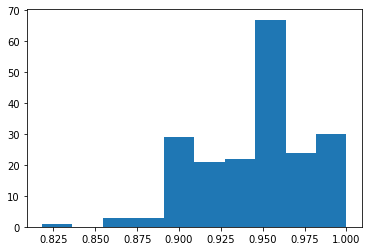

95.0 confidence interval 88.3% and 100.0%


In [25]:
# configure bootstrap to resample data
n_iterations = 200      # Number of bootstrap samples to create

# run bootstrap
stats = list()
for i in range(n_iterations):

	# prepare train and test sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
 
  # fit model
	model=RandomForestClassifier(max_depth=4,random_state=10)
	model.fit(X_train, y_train)
    
  # evaluate model
	score  = model.score(X_test , y_test)
	stats.append(score)


# plot scores

plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95                           # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))